# Rankings

Another placeholder.

Annual
Daily max and min: tide station
   
Map
Time Series
Samples:
Map showing …highest/lowest observed value at each location (MHHW) 

Plot of Station (relative) Time Series with
Top 10 max an min events …three day window
Color code El Nino, La Nina, neutral …the dots/stars?

Summary Tables and Arrows, Dials. Etc.
Table of Station (relative) Daily
Top 10 max and min events …three day window
Color code El Nino, La Nina, neutral



Text

## Setup

As with previous sections, we first need to import the necessary libraries, establish our input/output directories, and set up some basic plotting rules. We'll do this by running another notebook called "setup" and "plotting functions," and then we'll set our data and output paths. If you have not run the datawrangling notebook, you will need to do this before running this notebook. Note that this notebook is also largely a repeat of the anomaly notebook. 

```{margin}
```{note}
**TODO**

- Confirm numbers match
- Figure captions
- Figure labels
- Text
- Clean up code
- add commentary
 
```
```




In [38]:
%run ../setup.ipynb
%run ../plotting_functions.ipynb
data_dir = Path('../../data' )
output_dir = Path('../../output') 

# We're going to use plotly here, so we need to import it
import plotly.io as pio
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go

# check to make sure that data_dir/rsl_daily_hawaii.nc exists, if not, make warning to run datawrangling notebook
if not (data_dir / 'rsl_hawaii.nc').exists():
    print('rsl_hawaii.nc not found in '+ str(data_dir) +  '. Please run the data wrangling notebook first')
else:
    print('rsl_hawaii.nc found in '+ str(data_dir) +  '. Proceed.')

rsl_hawaii.nc found in ../../data. Proceed.


In [39]:
rsl_daily = xr.open_dataset(data_dir/ 'rsl_hawaii.nc')

In [40]:
rsl_daily = rsl_daily.sel(time=slice('1993','2023'))

rsl_daily

<xarray.Dataset> Size: 14MB
Dimensions:               (time: 271728, record_id: 11)
Coordinates:
  * time                  (time) datetime64[ns] 2MB 1993-01-01 ... 2023-12-31...
  * record_id             (record_id) int16 22B 140 500 520 ... 5470 5480 5520
Data variables:
    sea_level             (record_id, time) float32 12MB ...
    lat                   (record_id) float32 44B ...
    lon                   (record_id) float32 44B ...
    station_name          (record_id) <U17 748B ...
    station_country       (record_id) <U30 1kB ...
    station_country_code  (record_id) float32 44B ...
    uhslc_id              (record_id) float32 44B ...
    gloss_id              (record_id) float32 44B ...
    ssc_id                (record_id) <U4 176B ...
    last_rq_date          (record_id) datetime64[ns] 88B ...
    MHHW                  (record_id) float64 88B ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-03-07T14:27:49Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

In [41]:
#import rsl_daily
data_coverage = rsl_daily['sea_level'].count(dim='time')/len(rsl_daily.time)

data_coverage
#drop all locations with data_coverage less than 80%
rsl_subset = rsl_daily.where(data_coverage>0.80,drop=True)

# make sea level relative to MHHW, and convert to m
rsl_subset['sea_level'] = rsl_subset['sea_level'] - rsl_subset['MHHW']
rsl_subset['sea_level'] = rsl_subset['sea_level']/1000

# rename variable long name to sea level relative to MHHW
rsl_subset['sea_level'].attrs['long_name'] = 'sea level, MHHW'
rsl_subset['sea_level'].attrs['units'] = 'm'

In [42]:
# get min and max for each month by resampling
rsl_monthly_min = rsl_subset.resample(time='1ME').min()
rsl_monthly_max = rsl_subset.resample(time='1ME').max()
rsl_monthly_mean = rsl_subset.resample(time='1ME').mean()

/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/opt/anaconda3/envs/SLI39/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



## TO DO

```{note}
**TODO**

- make a function for the top10 


```

In [43]:
rid = 4


# Convert data to a pandas Series
sea_level_series = rsl_subset.sea_level.isel(record_id=rid).to_series()

# Get the initial set of largest 100 values to handle edge cases
top_values = sea_level_series.nlargest(100)

# Filter to find unique events spaced by at least 3 days
filtered_dates = []
top_10_values_max = pd.Series()

for date, value in top_values.items():
    if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
        filtered_dates.append(date)
        top_10_values_max[date] = value
    if len(filtered_dates) == 10:
        break

# Get the initial set of largest 100 values to handle edge cases
top_values = sea_level_series.nsmallest(100)

# Filter to find unique events spaced by at least 3 days
filtered_dates = []
top_10_values_min = pd.Series()

for date, value in top_values.items():
    if all(abs((date - pd.to_datetime(added_date)).days) > 3 for added_date in filtered_dates):
        filtered_dates.append(date)
        top_10_values_min[date] = value
    if len(filtered_dates) == 10:
        break

top_10_values_max

2015-09-17 15:00:00.000000    0.496
1994-10-04 22:59:59.971200    0.477
1995-11-24 13:59:59.971200    0.474
2020-12-15 13:59:59.971200    0.461
2017-08-21 00:00:00.000000    0.458
2021-12-05 13:59:59.971200    0.453
2019-12-26 13:00:00.028800    0.443
2023-08-02 01:00:00.028800    0.436
2020-07-21 01:00:00.028800    0.433
2020-07-06 01:59:59.971200    0.432
dtype: float64

In [44]:
# make a table of the top 10 values, sorted by size and with date

# first, round the date to the nearest whole hour
top_10_values_max.index = top_10_values_max.index.round('H')
top_10_values_min.index = top_10_values_min.index.round('H')

top_10_table_max = pd.DataFrame({'sea level (m)':top_10_values_max.values,
                                 'date':top_10_values_max.index})

top_10_table_min = pd.DataFrame({'sea level (m)':top_10_values_min.values,
                                    'date':top_10_values_min.index})


station_name = str(rsl_subset['station_name'].isel(record_id=rid).values)

def make_pretty_max(styler):
    styler.set_caption(station_name + ': Highest Events')
    styler.background_gradient(subset=['ONI'],axis=None, vmin=-2, vmax=2, cmap="RdBu_r")
    return styler

def make_pretty_min(styler):
    styler.set_caption(station_name + ': Lowest Events')
    styler.background_gradient(subset=['ONI'],axis=None, vmin=-2, vmax=2, cmap="RdBu_r")
    return styler


/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_5578/1156728078.py:4: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

/var/folders/qp/nn19rcjs5bdcdvxmff5bd3pr0000gn/T/ipykernel_5578/1156728078.py:5: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



In [45]:
# cross reference the dates with the oni data to see if they are during an El Nino or La Nina event
oni = pd.read_csv(data_dir / 'oni.csv', index_col='Date', parse_dates=True)

# Extract ONI values for the dates of the top 10 max events by finding the nearest dates
oni_max = oni.reindex(top_10_values_max.index, method='nearest')

# Repeat for the top 10 min events
oni_min = oni.reindex(top_10_values_min.index, method='nearest')


top_10_table_max['ONI'] = oni_max['ONI'].values
top_10_table_min['ONI'] = oni_min['ONI'].values
top_10_table_max['La Nina'] = oni_max['La Nina'].values
top_10_table_min['La Nina'] = oni_min['La Nina'].values
top_10_table_max['El Nino'] = oni_max['El Nino'].values
top_10_table_min['El Nino'] = oni_min['El Nino'].values

# oni_max

In [46]:
top_10_table_max.style.pipe(make_pretty_max)

,sea level (m),date,ONI,La Nina,El Nino
0,0.496000,2015-09-17 15:00:00,2.160000,False,True
1,0.477000,1994-10-04 23:00:00,0.740000,False,True
2,0.474000,1995-11-24 14:00:00,-1.000000,True,False
3,0.461000,2020-12-15 14:00:00,-1.190000,True,False
4,0.458000,2017-08-21 00:00:00,-0.110000,False,False
5,0.453000,2021-12-05 14:00:00,-0.980000,True,False
6,0.443000,2019-12-26 13:00:00,0.550000,False,False
7,0.436000,2023-08-02 01:00:00,1.320000,False,True
8,0.433000,2020-07-21 01:00:00,-0.410000,False,False
9,0.432000,2020-07-06 02:00:00,-0.410000,False,False


In [47]:
top_10_table_min.style.pipe(make_pretty_min)

,sea level (m),date,ONI,La Nina,El Nino
0,-2.016000,2011-03-11 15:00:00,-0.930000,True,False
1,-1.024000,2010-02-28 03:00:00,1.220000,False,True
2,-0.952000,2011-12-25 06:00:00,-1.040000,True,False
3,-0.943000,1998-06-24 18:00:00,-0.130000,False,False
4,-0.933000,1999-01-02 06:00:00,-1.550000,True,False
5,-0.923000,2001-06-24 21:00:00,-0.120000,False,False
6,-0.921000,2009-05-25 19:00:00,0.010000,False,False
7,-0.911000,2009-06-23 18:00:00,0.280000,False,False
8,-0.910000,2009-01-10 05:00:00,-0.850000,True,False
9,-0.903000,2010-01-01 07:00:00,1.500000,False,True


In [48]:
#make extremes table
#combine max and min tables, keeping the index as rank
top_10_table = pd.concat([top_10_table_max,top_10_table_min],keys=['max','min'],names=['rank'])
top_10_table

sea level (m)                date   ONI  La Nina  El Nino
rank                                                             
max  0          0.496 2015-09-17 15:00:00  2.16    False     True
     1          0.477 1994-10-04 23:00:00  0.74    False     True
     2          0.474 1995-11-24 14:00:00 -1.00     True    False
     3          0.461 2020-12-15 14:00:00 -1.19     True    False
     4          0.458 2017-08-21 00:00:00 -0.11    False    False
     5          0.453 2021-12-05 14:00:00 -0.98     True    False
     6          0.443 2019-12-26 13:00:00  0.55    False    False
     7          0.436 2023-08-02 01:00:00  1.32    False     True
     8          0.433 2020-07-21 01:00:00 -0.41    False    False
     9          0.432 2020-07-06 02:00:00 -0.41    False    False
min  0         -2.016 2011-03-11 15:00:00 -0.93     True    False
     1         -1.024 2010-02-28 03:00:00  1.22    False     True
     2         -0.952 2011-12-25 06:00:00 -1.04     True    False
     3         -0.943 1998-06-24 18:00:00 -0.13    False    False
     4         -0.933 1999-01-02 06:00:00 -1.55     True    False
     5         -0.923 2001-06-24 21:00:00 -0.12    False    False
     6         -0.921 2009-05-25 19:00:00  0.01    False    False
     7         -0.911 2009-06-23 18:00:00  0.28    False    False
     8         -0.910 2009-01-10 05:00:00 -0.85     True    False
     9         -0.903 2010-01-01 07:00:00  1.50    False     True

In [49]:
figly = go.Figure()
rid = 4

x  = rsl_monthly_mean.time - np.timedelta64(15,'D') # add 15 days to make the line in the middle of the month

 #make a fill from max to min for each month
figly.add_trace(go.Scatter(x =x, y = rsl_monthly_max['sea_level'].isel(record_id=rid), mode='lines', line_color='rgba(0,176,246,0.2)', name='Monthly Max'))
figly.add_trace(go.Scatter(x =x, y = rsl_monthly_min['sea_level'].isel(record_id=rid), mode='lines', line_color='rgba(0,176,246,0.2)', fill='tonexty', fillcolor='rgba(0,176,246,0.2)', name='Range (Monthly Max/Min)'))

figly.add_trace(go.Scatter(x =x, y = rsl_monthly_mean['sea_level'].isel(record_id=rid), mode='lines', line_color='rgba(0,176,246,1)', name='Monthly Mean'))

# add the top 10 values if La Nina is true
figly.add_trace(go.Scatter(x=top_10_table[top_10_table['La Nina']].date,
                            y=top_10_table[top_10_table['La Nina']]['sea level (m)'],
                            mode='markers', marker=dict(color='blue', size=12,symbol='circle'), name='La Niña',
                            hoverinfo ='none'))

figly.add_trace(go.Scatter(x=top_10_table[top_10_table['El Nino']].date,
                            y=top_10_table[top_10_table['El Nino']]['sea level (m)'],
                            mode='markers', marker=dict(color='red', size=12,symbol='star'), name='El Niño',
                            hoverinfo = 'none'))

figly.add_trace(go.Scatter(x=top_10_table.date,
                            y=top_10_table['sea level (m)'],
                            mode='markers', marker=dict(color='orange', size=6,symbol='circle'), name='Highest/Lowest Events',
                            hovertemplate='%{x}, %{y:.2f} m<extra></extra>'))


figly.update_layout(title=str(rsl_subset['station_name'].isel(record_id=rid).values), xaxis_title='Time', yaxis_title=rsl_subset['sea_level'].attrs['long_name']+ ' ['+rsl_subset['sea_level'].attrs['units']+']', showlegend=True)

# cut time range to show only between 1993 and 2023
figly.update_xaxes(range=['1993-01-01','2023-12-31'])

# make the background color white, with a border, and grey gridlines every 5 years
figly.update_layout(plot_bgcolor='white', xaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)'),
                  yaxis=dict(showgrid=True, gridwidth=0.5, gridcolor='rgb(200,200,200)'))

# Update layout to make the plot responsive
figly.update_layout(
    autosize=True,  # Enable autosize to adjust both width and height
)

#put the legend under the plot
figly.update_layout(legend=dict(orientation='h', y=1.1, x=0.5, xanchor='center', yanchor='top'))

#make the title centered over plot and bigger and bold
figly.update_layout(title_x=0.5, title_font_size=24, title_font_family='Arial', title_font_color='black', title_font=dict(size=20, color='black'))

figly.show()


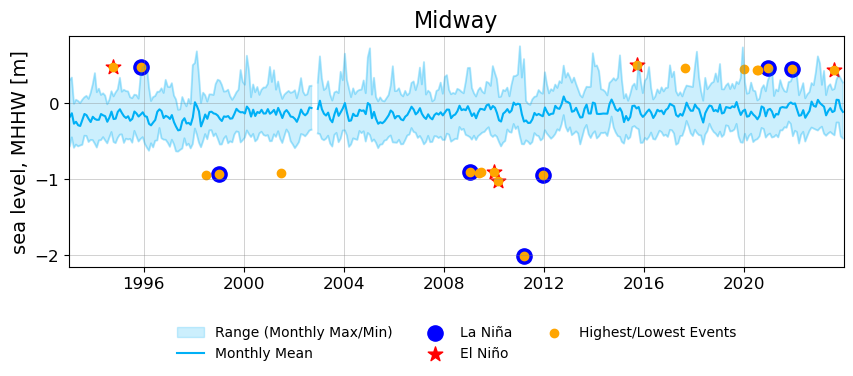

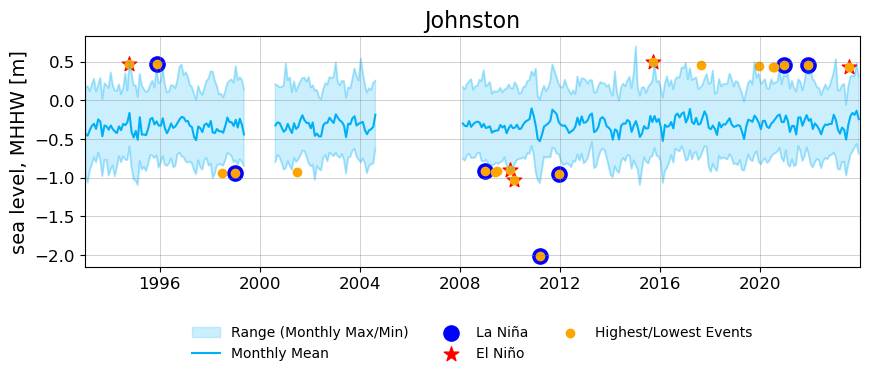

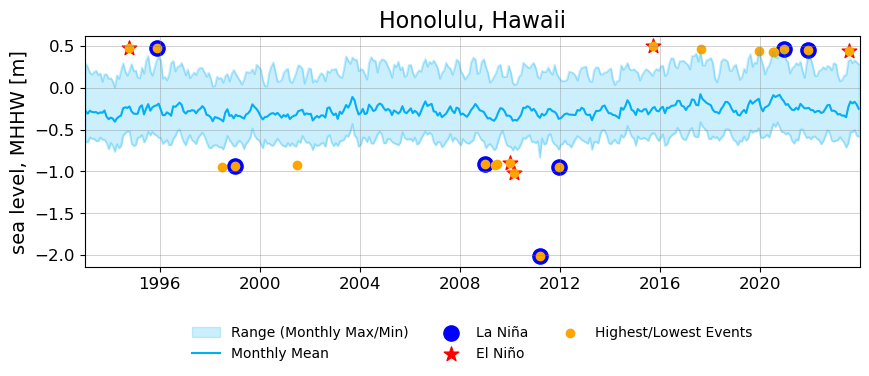

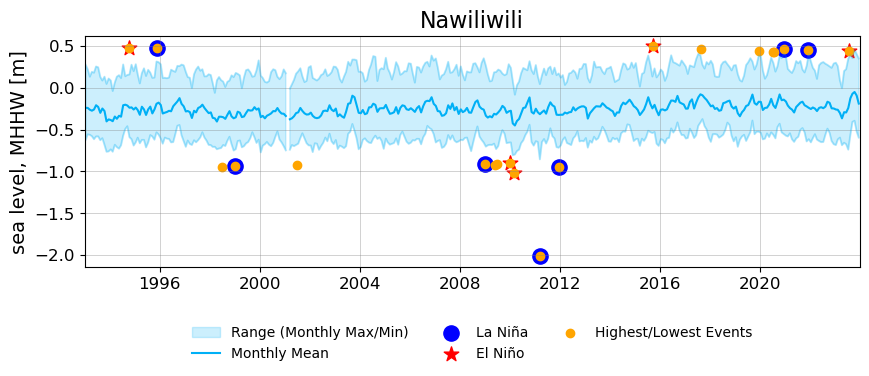

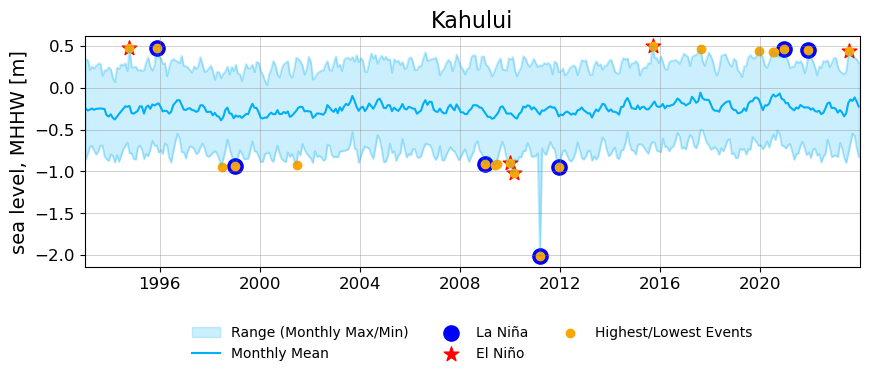

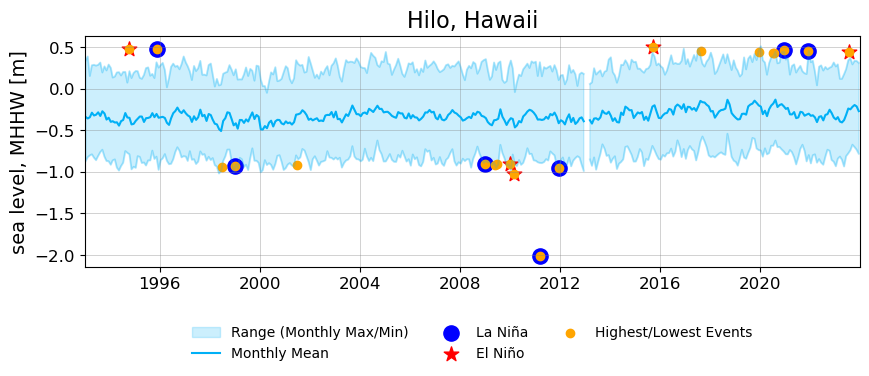

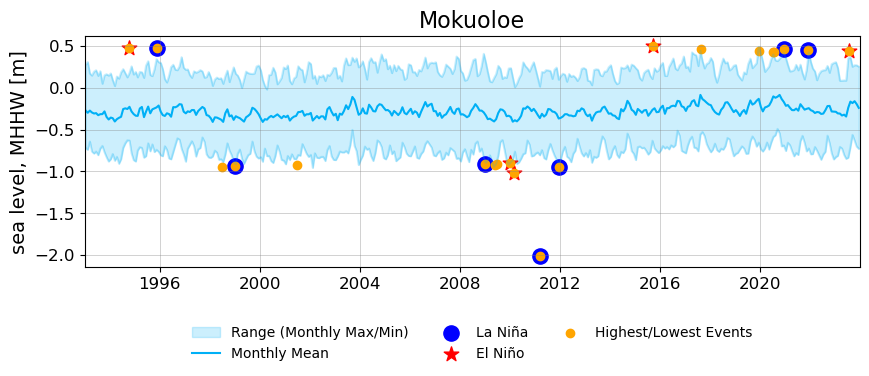

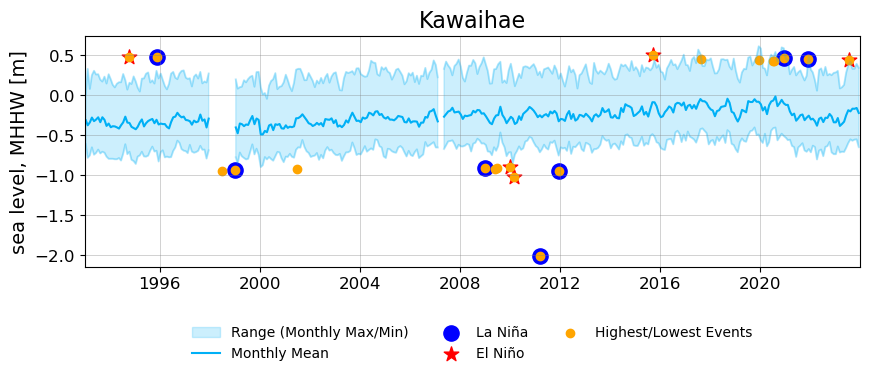

In [51]:
# static version

# Plot configuration

# loop through all the records
for i in range(len(rsl_subset.record_id)):
    rid = i

    # get top_10_table for each record

    fig,ax = plt.subplots(1,1,figsize=(10,3))
    
    
    ax.set_title(f'{rsl_subset["station_name"].isel(record_id=rid).values}')
    ax.set_ylabel(f'{rsl_subset["sea_level"].attrs["long_name"]} [{rsl_subset["sea_level"].attrs["units"]}]')
    
    # Plot the max, min, and mean lines
    # Plot the max, min, and mean lines
    ax.plot(x, rsl_monthly_max['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2))
    ax.plot(x, rsl_monthly_min['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2))
    ax.fill_between(x, rsl_monthly_max['sea_level'].isel(record_id=rid), 
                     rsl_monthly_min['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 0.2), label='Range (Monthly Max/Min)')
    ax.plot(x, rsl_monthly_mean['sea_level'].isel(record_id=rid), color=(0/255, 176/255, 246/255, 1), label='Monthly Mean')
    
    # Plot the markers for La Niña, El Niño, and other events
    ax.scatter(top_10_table[top_10_table['La Nina']].date, top_10_table[top_10_table['La Nina']]['sea level (m)'], color='blue', s=120, label='La Niña', marker='o')
    ax.scatter(top_10_table[top_10_table['El Nino']].date, top_10_table[top_10_table['El Nino']]['sea level (m)'], color='red', s=120, label='El Niño', marker='*')
    ax.scatter(top_10_table.date, top_10_table['sea level (m)'], color='orange', s=36, label='Highest/Lowest Events', marker='o')
    
    # Setting the x-axis limits
    ax.set_xlim(pd.Timestamp('1993-01-01'), pd.Timestamp('2023-12-31'))
    
    # Improve the appearance
    ax.grid(True, color='gray', alpha=0.5 ,linewidth=0.5)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False, fontsize=10)
    
    
    # Save the plot to a file
    figname = 'SL_rankings_' + str(rsl_subset['station_name'].isel(record_id=rid).values) + '.png'
    fig.savefig(output_dir / figname, dpi=300, bbox_inches='tight')


glue("SL_rankings",fig,display=False)


```{glue:figure} SL_rankings
:name: "SL_rankings"

This is a static version of the previous figure. I am using this static version because there is more control over the printed figure.
```